# 1. Import Library

In [1]:
import sys

sys.path.append('../')

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

import selfies as sf
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt

# Import your custom functions and classes from the vae_module.py
from src.vae import flatten
from src.vae import VAE
from src.vae import train_vae

# 2. Import Data

In [2]:
data = pd.read_csv('../data/test_more_dataNoinionc.csv', header=None, names=['smiles', 'logCMC'])
print(data.shape)
data.head()

(285, 2)


,smiles,logCMC
0,CC(C)(C)CC(C)(C)c1ccc(OCCOCCO)cc1,-0.886057
1,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCO)cc1,-1.013228
2,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCOCCO)cc1,-0.886057
3,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCOCCOCCO)cc1,-0.823909
4,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCOCCOCCOCCO)cc1,-0.677781


In [3]:
import seaborn as sns

def plot_data(data, figsize=(10, 6)):

    fig = plt.gcf().set_size_inches(figsize)
    sns.histplot(data['logCMC'], kde=True)
    
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 13
    plt.rcParams['figure.dpi'] = 600
    # set font size for tick labels
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    # Display the histogram
    plt.show()

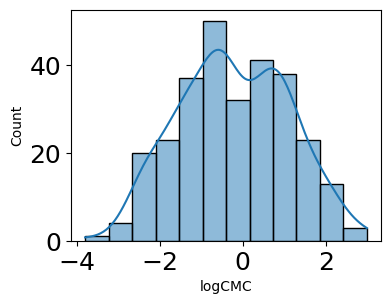

In [4]:
plot_data(data, figsize=(4, 3))

In [5]:
# 

def plot_missing_count(figsize=(10, 6)):

    # Create histogram

    fig = plt.gcf().set_size_inches(figsize)
    plt.barh(labels, missing_percentages, color=colors)
    
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 13
    plt.rcParams['figure.dpi'] = 600

    # Set labels and title
    plt.xlabel('% Missing Values', fontsize=14)
    # set font size for tick labels
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    # Display the histogram
    plt.show()

In [6]:
input_smiles_list = data.iloc[:, 0].tolist()
input_selfies_list = list(map(sf.encoder, input_smiles_list))

# Parameters for encoding
max_len = max(sf.len_selfies(s) for s in input_selfies_list)
alphabet = sf.get_alphabet_from_selfies(input_selfies_list)
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}

# Convert SELFIES to one-hot encoding
input_one_hot_arr = np.array([sf.selfies_to_encoding(s, vocab_stoi, pad_to_len=max_len)[1] for s in input_selfies_list])

# split data
x_train, x_val = train_test_split(input_one_hot_arr, test_size=0.2, random_state=104)

## Convert the "input_one_hot_arr" dataset to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)


In [7]:
input_one_hot_arr.shape

(285, 151, 24)

In [8]:
# Flatten the input data using the custom 'flatten' function
# This function takes a 3D tensor 'x_train' and reshapes it into a 2D tensor
width_train, height_train, input_dim_train, flattened_dataset_train = flatten(x_train)
width_val, height_val, input_dim_val, flattened_dataset_val = flatten(x_val)

In [9]:
print(f"Original shape of the training: {x_train.shape}, validation: {x_val.shape} datasets")
print(f"Flattened shape of the training: {flattened_dataset_train.shape}, validation: {flattened_dataset_val.shape} datasets")
print(f'Same width for training and validation datasets: {width_train == width_val}')
print(f'Same height for training and validation datasets: {height_train == height_val}')
print(f'Same input dimension for training and validation datasets: {input_dim_train == input_dim_val}')

Original shape of the training: torch.Size([228, 151, 24]), validation: torch.Size([57, 151, 24]) datasets
Flattened shape of the training: torch.Size([228, 3624]), validation: torch.Size([57, 3624]) datasets
Same width for training and validation datasets: True
Same height for training and validation datasets: True
Same input dimension for training and validation datasets: True


# 3. Train Generative Model

In [10]:
# Create a PyTorch dataset and data loader for training
batch_size = 64  # Batch size for training
train_loader = DataLoader(TensorDataset(flattened_dataset_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(flattened_dataset_val), batch_size=batch_size, shuffle=False)

In [11]:
# Define hyperparameters
latent_dim = 32  # Dimensionality of the latent space
num_epochs = 1000  # Number of training epochs
# Create a VAE model instance
vae = VAE(input_dim_train, latent_dim)
input_dim_pretrained = 4920
# Load the pre-trained VAE model
pretrained_vae = VAE(input_dim_pretrained, latent_dim)  # Use the appropriate input_dim_pretrained
pretrained_vae.load_state_dict(torch.load('../models/pretrained_vae.pt'))

<All keys matched successfully>

In [12]:
# Transfer weights to the corresponding layers in your current VAE model
with torch.no_grad():
    # Transfer encoder weights
    vae.encoder[0].weight.copy_(pretrained_vae.encoder[0].weight[:, :input_dim_train])

    # Transfer decoder weights
    vae.decoder[2].weight.copy_(pretrained_vae.decoder[2].weight[:input_dim_train, :])

    # Update the decoder bias dimensions
    vae.decoder[2].bias.copy_(pretrained_vae.decoder[2].bias[:input_dim_train])


#Define the optimizer for training the VAE model
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the VAE model using the 'train_vae' function
train_vae(vae, train_loader, val_loader, optimizer, num_epochs)

2024-03-07 11:38:23.869 | INFO     | src.vae:train_vae:183 - Epoch [1/1000], Train Loss: 3272.311, Val Loss: 13089.245
2024-03-07 11:38:23.905 | INFO     | src.vae:train_vae:183 - Epoch [2/1000], Train Loss: 3043.213, Val Loss: 12172.853
2024-03-07 11:38:23.941 | INFO     | src.vae:train_vae:183 - Epoch [3/1000], Train Loss: 2894.217, Val Loss: 11576.866
2024-03-07 11:38:23.978 | INFO     | src.vae:train_vae:183 - Epoch [4/1000], Train Loss: 2745.672, Val Loss: 10982.689
2024-03-07 11:38:24.015 | INFO     | src.vae:train_vae:183 - Epoch [5/1000], Train Loss: 2540.907, Val Loss: 10163.627
2024-03-07 11:38:24.052 | INFO     | src.vae:train_vae:183 - Epoch [6/1000], Train Loss: 2425.061, Val Loss: 9700.242
2024-03-07 11:38:24.089 | INFO     | src.vae:train_vae:183 - Epoch [7/1000], Train Loss: 2308.920, Val Loss: 9235.682
2024-03-07 11:38:24.128 | INFO     | src.vae:train_vae:183 - Epoch [8/1000], Train Loss: 2160.802, Val Loss: 8643.207
2024-03-07 11:38:24.163 | INFO     | src.vae:train_

In [13]:
# set random seed for reproducibility
torch.manual_seed(104)
# Generate molecules from the trained VAE
vae.eval()
num_samples = 500  # generate a sample
with torch.no_grad():
    # Generate latent samples from a standard normal distribution
    latent_samples = torch.randn(num_samples, latent_dim)
    # generate molecules from the latent samples
    generated_molecules = vae.decoder(latent_samples)
    # encode the generated molecules
    encoded_latent_generated = vae.encoder(generated_molecules)
print(generated_molecules)

tensor([[1.1353e-05, 1.1445e-05, 1.0909e-05,  ..., 9.3021e-06, 5.8260e-06,
         8.9302e-01],
        [3.2966e-05, 2.1578e-05, 2.1276e-05,  ..., 1.8355e-05, 1.2953e-05,
         9.4941e-01],
        [8.7634e-04, 8.8057e-04, 9.0880e-04,  ..., 7.5808e-04, 9.0004e-04,
         7.7803e-01],
        ...,
        [8.9082e-04, 9.2857e-04, 8.7645e-04,  ..., 8.1012e-04, 8.3793e-04,
         4.0424e-01],
        [1.1503e-03, 1.1148e-03, 1.5921e-03,  ..., 1.1941e-03, 1.3338e-03,
         3.2798e-01],
        [7.9705e-04, 5.7599e-04, 6.1523e-04,  ..., 3.7605e-04, 3.8773e-04,
         6.1426e-01]])


In [14]:
latent_samples = torch.randn(num_samples, latent_dim)
latent_samples.shape

torch.Size([500, 32])

In [15]:
def generate_new_molecules(vae, num_samples = 500, latent_dim = 32):
        """
        Generate new molecules from the trained VAE
        Args:
            num_samples : int, number of samples to generate
        Returns:
            encoded_generated : PyTorch tensor, encoded generated molecules
        """
        vae.eval()
        with torch.no_grad():
            latent_samples = torch.randn(num_samples, latent_dim)
            decoded_generated = vae.decoder(latent_samples)
            encoded_generated = vae.encoder(decoded_generated)

        return decoded_generated

# Generate new molecules
encoded_generated = generate_new_molecules(vae, num_samples=10, latent_dim=latent_dim)
encoded_generated.shape

torch.Size([10, 3624])

In [16]:
def generated_molecules_to_smiles(
                                    generated_molecules, 
                                    width, height, 
                                    vocab_itos):
    """
    Convert the generated molecules to SMILES representation
    Args:
        generated_molecules : PyTorch tensor
        width : int, width of the 2D tensor
        height : int, height of the 2D tensor
        vocab_itos : dict, vocabulary to index mapping
    Returns:
        output_smiles_list : list, SMILES representation of the generated molecules
    """
    # Reshape satisfying_molecules_tensor back to a 3D tensor
    generated_molecules_tensor_3d = generated_molecules.view(-1, width, height) 
    # Convert the PyTorch 3D tensor to a NumPy array
    generated_molecules_numpy = generated_molecules_tensor_3d.numpy()
    max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
    generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)
    ## Reproduce SMILES list and visualize the output images
    output_smiles_list = []
    for i in range (0,len(generated_data)):
        sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
        output_smiles_list.append(sm)

    return output_smiles_list

In [17]:
smiles = generated_molecules_to_smiles(encoded_generated,
                                       width=width_train,
                                       height=height_train,
                                       vocab_itos=vocab_itos)   
smiles

['CCCCCCCCCC[C@@H1]=NCC(C)C(O)\\CC=N/C=C=CCF',
 'N12CCCC=NN(N1N)NC(CO/C2=C=O)F',
 'CCCCCCCC/CC[C@@H1]OC(C1)C1[C@@H1]',
 'NCCCF',
 'N12CCCC=NN1COC2=NNNC(N[C@@H1]/CO)N=O',
 'C12CCCC=NCC/CNCOC1CCN[C@@H1]C\\CCOSPN2',
 'CCCCCCCCCCCOCC(C)C(=C1)C1N/CP[C@@H1]=N/CN(/C(/C/C)[C@@H1]F)C[C@@H1]CCCO',
 'N1CCCC=NN(NOC1=NNNC)N(CO/CN)ONF',
 'C1CCCCCCCCCC=NCCNCCCN[C@@H1]1',
 'N1CC(=N)CCCC[C@@H1]OC1CCC(\\C)CO/C/C[C@H1]=[C@@H1]']

In [18]:
def set_figure_properties():
    """
    Set the properties for the figure
    """
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                                    ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 13
    plt.rcParams['figure.dpi'] = 600

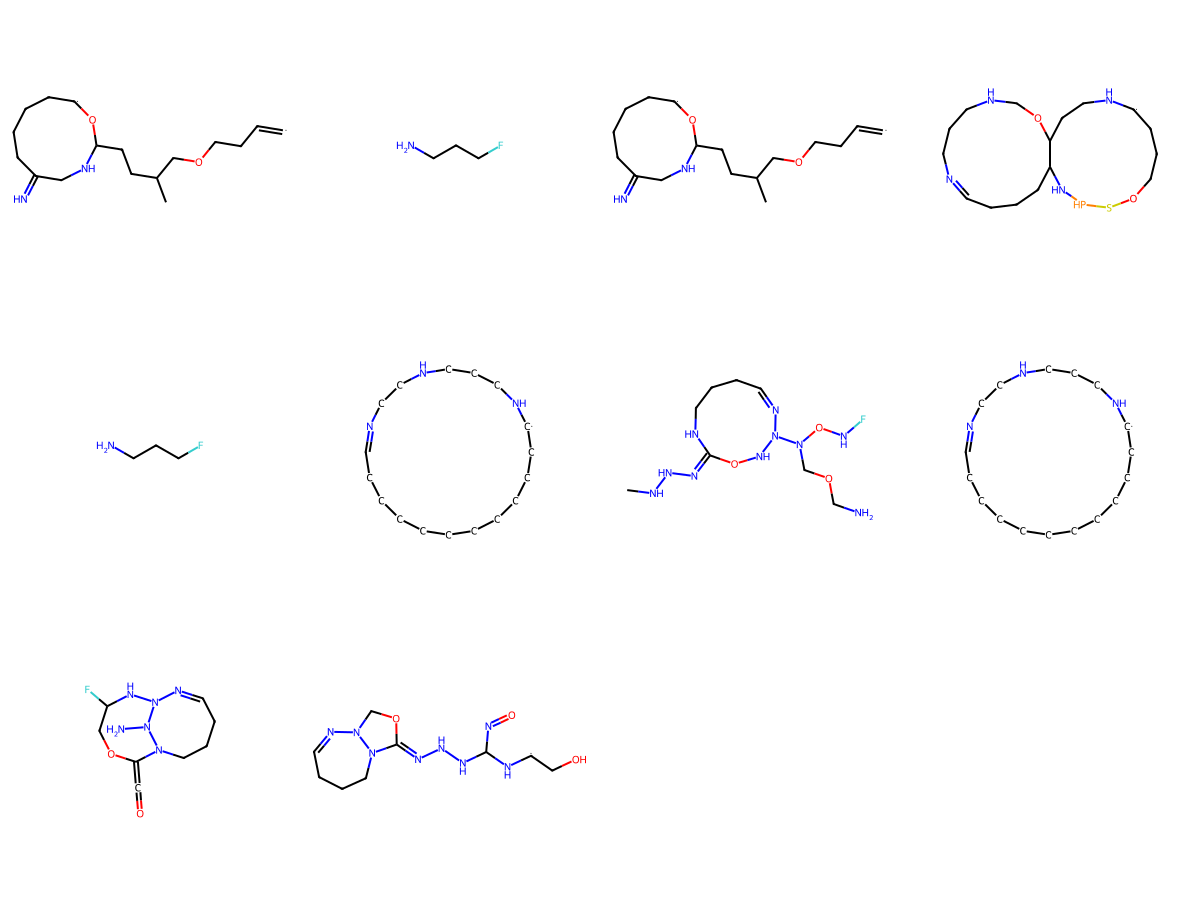

In [19]:
from rdkit import Chem
import datamol as dm

random_smiles = np.random.choice(smiles, 10)


mols=[Chem.MolFromSmiles(x) for x in random_smiles]
dm.to_image(mols)

# 4. The Problem

In [20]:
# set width and height
if width_train == width_val and height_train == height_val:
    width = width_train
    height = height_train
    print (f'Setting width and height to {width} and {height}, respectively')

Setting width and height to 151 and 24, respectively


In [21]:
torch.randn(num_samples, latent_dim)

tensor([[-0.1218, -0.1780,  0.7873,  ...,  0.3666,  0.7189,  0.9483],
        [ 0.3904,  0.8155,  0.0969,  ...,  1.6057, -0.0447,  1.8220],
        [-0.8343, -0.9070,  0.5301,  ...,  1.3253, -0.8987,  0.4563],
        ...,
        [-0.6827,  0.4897, -0.0228,  ..., -0.0221, -0.6121,  0.3059],
        [-0.3731,  0.3507, -0.5149,  ...,  0.6092,  1.0156, -1.0849],
        [ 1.0023,  0.7358, -1.5147,  ...,  0.3014, -0.2254,  1.2142]])

In [22]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.neighbors import NearestNeighbors

class MoleculeGuidedSearch:
    def __init__(self, 
                    latent_space: torch.tensor,
                    vae: nn.Module,
                    X: int, width: int, height: int, vocab_itos: dict, **kwargs):
        self.vae = vae # trained VAE model
        self.X = X # training data 
        self.width = width # width of the 2D tensor
        self.height = height # height of the 2D tensor
        self.latent_space = latent_space # latent_space = torch.randn(num_samples, latent_dim)
        self.vocab_itos = vocab_itos # vocabulary to index mapping

    def generate_new_molecules(self, vae, latent_space):
        """
        Generate new molecules from the trained VAE
        Args:
            num_samples : int, number of samples to generate
        Returns:
            encoded_generated : PyTorch tensor, encoded generated molecules
        """
        vae.eval()
        with torch.no_grad():
            decoded_generated = vae.decoder(latent_space)
            encoded_generated = vae.encoder(decoded_generated)

        return decoded_generated
        
    def number2smiles(self, 
                        generated_encoder, 
                        width: int, height: int, vocab_itos):
        """
        Convert the generated molecules to SMILES representation
        Args:
            generated_molecules : PyTorch tensor
            width : int, width of the 2D tensor
            height : int, height of the 2D tensor
            vocab_itos : dict, vocabulary to index mapping
        Returns:
            output_smiles_list : list, SMILES representation of the generated molecules
        """
        # Reshape satisfying_molecules_tensor back to a 3D tensor
        generated_molecules_tensor = generated_encoder.view(-1, width, height) 
        # Convert the PyTorch 3D tensor to a NumPy array
        generated_molecules_np = generated_molecules_tensor.numpy()
        max_val = np.max(generated_molecules_np, axis=2, keepdims=True)
        generated_data = np.where(generated_molecules_np == max_val, 1, 0)
        ## Reproduce SMILES list and visualize the output images
        output_smiles_list = []
        for i in range (0, len(generated_data)):
            sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
            output_smiles_list.append(sm)

        return output_smiles_list

    
    def valid_smiles(self, smiles: list):
        '''return the valid smiles
        Args: smiles: list of smiles
        Returns: valid_smiles: list of valid smiles, their index & print the % of valid smiles
        '''
        valid_smiles = []
        index = []
        for idx, sm in enumerate(smiles):
            mol = Chem.MolFromSmiles(sm)
            if mol:
                valid_smiles.append(sm)
                index.append(idx)
        
        #print(f'% of valid smiles: {100*len(valid_smiles)/len(smiles)}')
        
        return np.array(valid_smiles)

    def knn_neighbor(self, X, neighbors: int = 5):

        nbrs = NearestNeighbors(n_neighbors = neighbors).fit(X)
        
        return nbrs

    def execute(self):
        # STEP 1. generate new molecules
        encoded_generated = self.generate_new_molecules(vae=self.vae, latent_space=self.latent_space)
        #print(encoded_generated.shape)
        #print(encoded_generated)
        # STEP 2. compute the distance
        knn = self.knn_neighbor(self.X.reshape(-1, self.width*self.height), neighbors=5)
        new_samples = encoded_generated.reshape(-1, self.width*self.height)
        distances, _ = knn.kneighbors(new_samples, return_distance=True)
        max_distance = np.max(distances, axis=1)
        # STEP 3. get the property
        smiles = self.number2smiles(encoded_generated, self.width, self.height, self.vocab_itos)
        valid_smiles = self.valid_smiles(smiles)
        desired_property = np.array([Descriptors.MolLogP(Chem.MolFromSmiles(sm)) for sm in valid_smiles])

        return desired_property, max_distance, valid_smiles


In [23]:
problem = MoleculeGuidedSearch(
                    vae = vae, X = input_one_hot_arr, 
                    latent_space = torch.randn(10, 32), # torch.from_numpy(np.random.rand(10, 32))
                    width = width, height = height, vocab_itos = vocab_itos)
computed_property, max_distance, smiles = problem.execute()
max_distance.shape, computed_property.shape, len(smiles),

((10,), (10,), 10)

In [43]:
problem = MoleculeGuidedSearch(
                    vae = vae, X = input_one_hot_arr, 
                    latent_space = torch.tensor(np.random.rand(500, 32), dtype=torch.float32),
                    width = width, height = height, vocab_itos = vocab_itos)
computed_property, max_distance, smiles = problem.execute()
max_distance.shape, computed_property.shape, len(smiles),

((500,), (500,), 500)

In [67]:
# add generated and experimental data to same dataframe
generated_data = pd.DataFrame({'smiles': smiles, 'tag': ['mdl']*len(smiles)})
exp_data = pd.DataFrame({'smiles': input_smiles_list, 'tag': ['exp']*len(input_smiles_list)})
# merge the two dataframes
merged_data = pd.concat([exp_data, generated_data], axis=0)
print(merged_data.shape)
merged_data.head()

(785, 2)


,smiles,tag
0,CC(C)(C)CC(C)(C)c1ccc(OCCOCCO)cc1,exp
1,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCO)cc1,exp
2,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCOCCO)cc1,exp
3,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCOCCOCCO)cc1,exp
4,CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCOCCOCCOCCO)cc1,exp


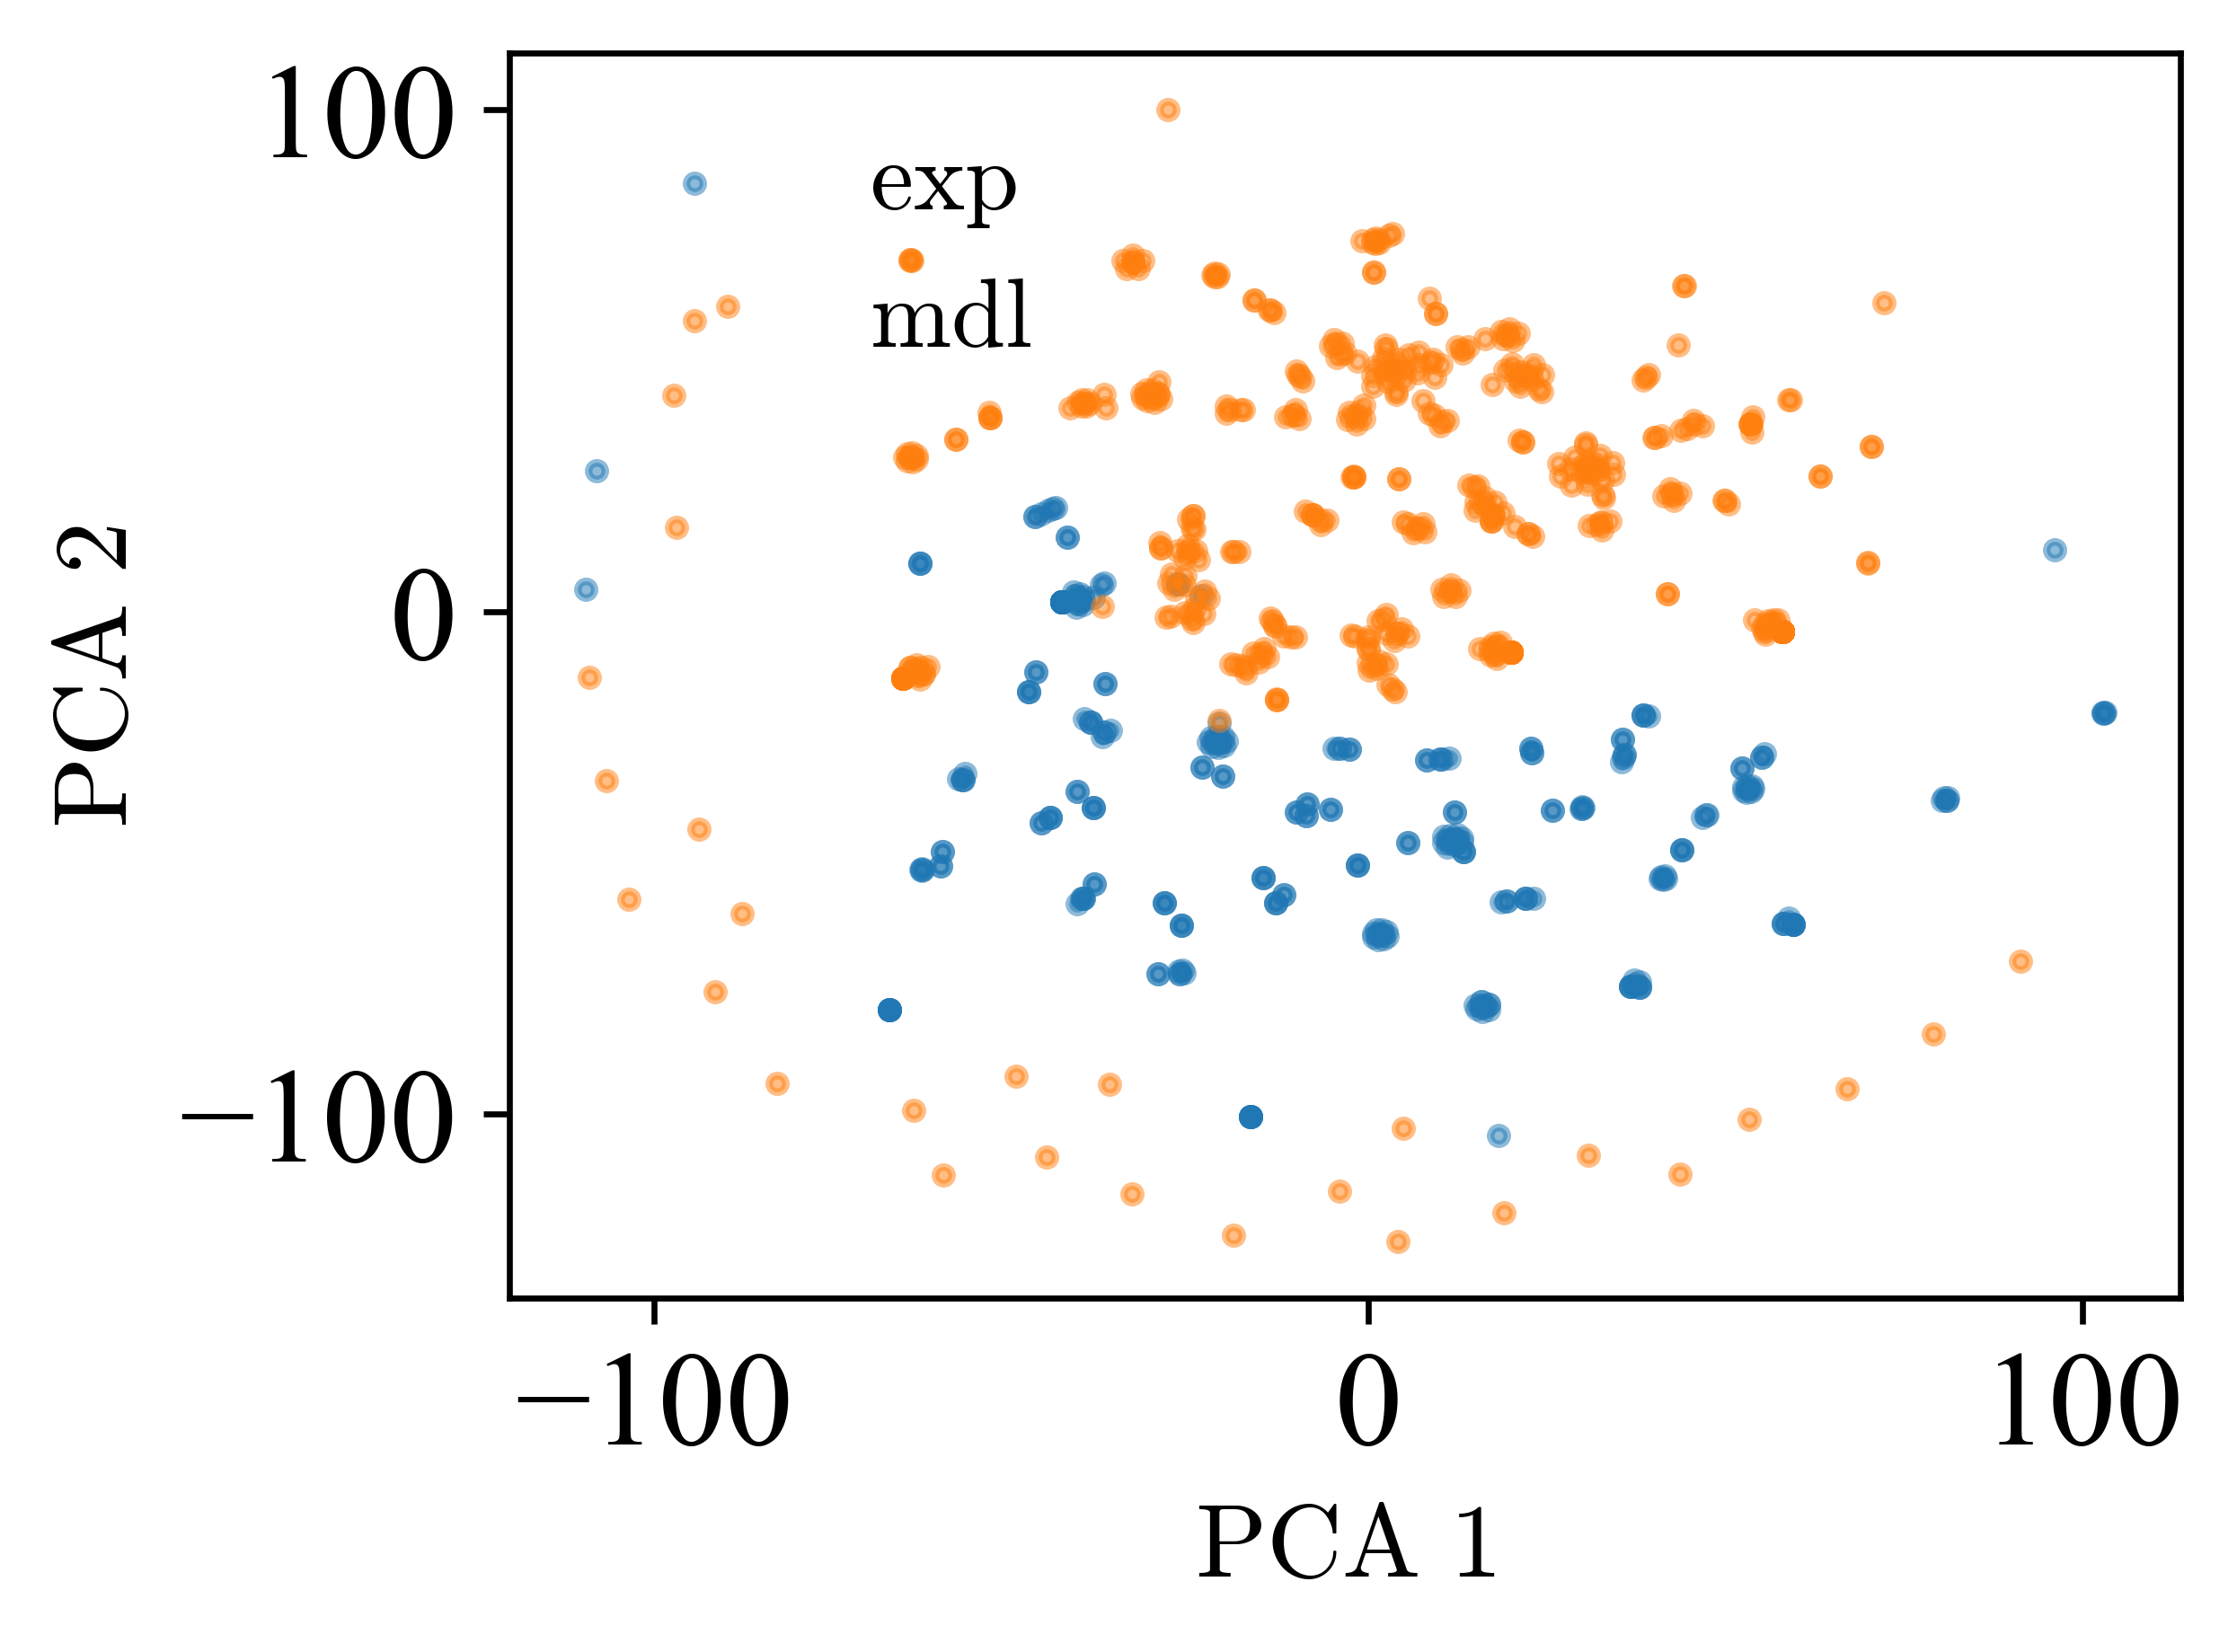

In [84]:
# show tnse plot with morgan fingerprints
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from rdkit.Chem import AllChem

def plot_map(data, figsize=(3, 2)):
    """
    Plot a t-SNE plot of the data
    Args:
        data : pd.DataFrame, data to plot
        figsize : tuple, size of the figure
    """
    fig = plt.gcf().set_size_inches(figsize)
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 13
    plt.rcParams['figure.dpi'] = 600

    pca = PCA(n_components=2)
    X = np.array([ AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=2048) for x in data['smiles']])

    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', 
                        perplexity=3, random_state=0).fit_transform(X)
    # get the unique tags
    tags = data['tag'].unique()
    # plot the data
    for tag in tags:
        plt.scatter(X_embedded[data['tag'] == tag, 0], 
                    X_embedded[data['tag'] == tag, 1], 
                    label=tag, s=5, alpha=0.5)
    
    plt.legend([r'$\rm exp$', r'$\rm mdl$'], loc='best', frameon=False)
    plt.xlabel(r'$\rm PCA \ 1$', fontsize=14)
    plt.ylabel(r'$\rm PCA \ 2$', fontsize=14)

    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)

    plt.show()

plot_map(merged_data, figsize=(4, 3))

# 5. Optimization

In [ ]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.core.mixed import (MixedVariableMating, MixedVariableSampling, 
                            MixedVariableDuplicateElimination)
from pymoo.optimize import minimize

In [ ]:
class MolProblem(ElementwiseProblem):
    def __init__(self, **kwargs):
        super().__init__(n_var=1*32, n_obj = 2, xu=1, xl=0, n_constr = 0, vtype=float)

    def _evaluate(self, X, out, *args, **kwargs):

        problem = MoleculeGuidedSearch(
                    vae = vae, X = input_one_hot_arr, 
                    latent_space = torch.tensor(np.reshape(X, (1, 32)), dtype=torch.float32),
                    width = width, height = height, vocab_itos = vocab_itos)

        # objective functions
        f1, f2, _ = problem.execute()
        # constraint
        # set desired property to be greater than 3, f1 >= 3, -f1 <= -3
        #f3 = -f1 + 3 
        # set distance to not be greater than 5, f2 <= 5, 
        #f4 = f2 - 5

        #print(f'Shape of f1: {f1.shape}, f2: {f2.shape}, f3: {f3.shape}, f4: {f4.shape}')
        
        out["F"] = [-f1, f2]
        #out["G"] = [f3, f4]

problem = MolProblem()
algorithm = NSGA2(pop_size=50)
result = minimize(problem, 
                  algorithm, ('n_gen', 100), 
                  seed=1, save_history=True, verbose=True)

In [ ]:
result.X.shape, result.F.shape